# Master Thesis Notebook

## Setup

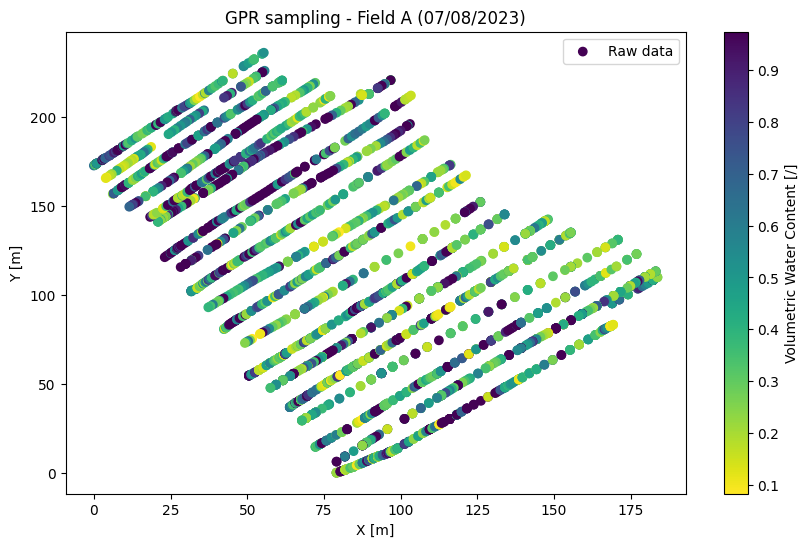

In [1]:
# Importation of the classes and methods associated
from classes import *

## GPR VWC Analysis

### Raw data

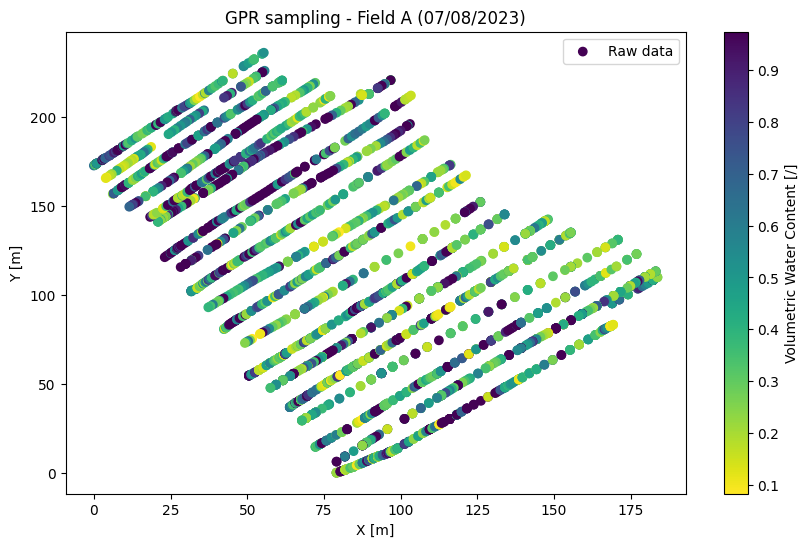

In [2]:
# Instance creation
gpr_a = GprAnalysis(field_letter="A", sample_number=0)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_a.plot_raw_data()

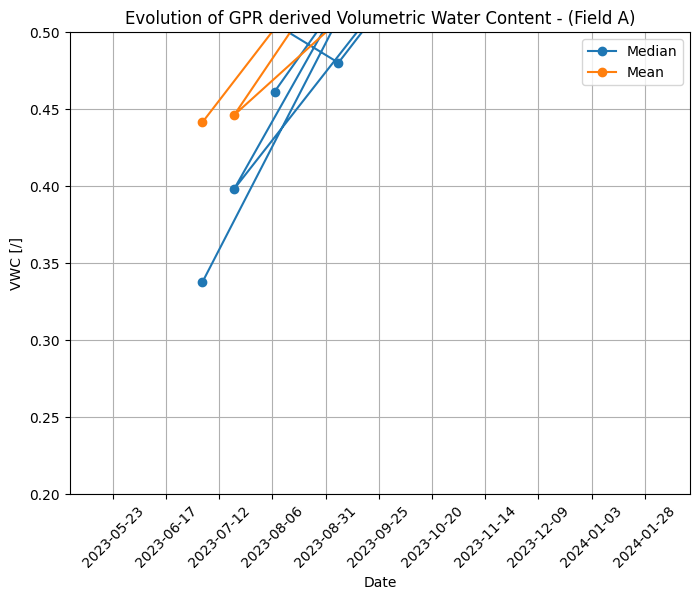

In [3]:
# Mean and median evolution (raw data)
gpr_a.plot_mean_median(plot=True)

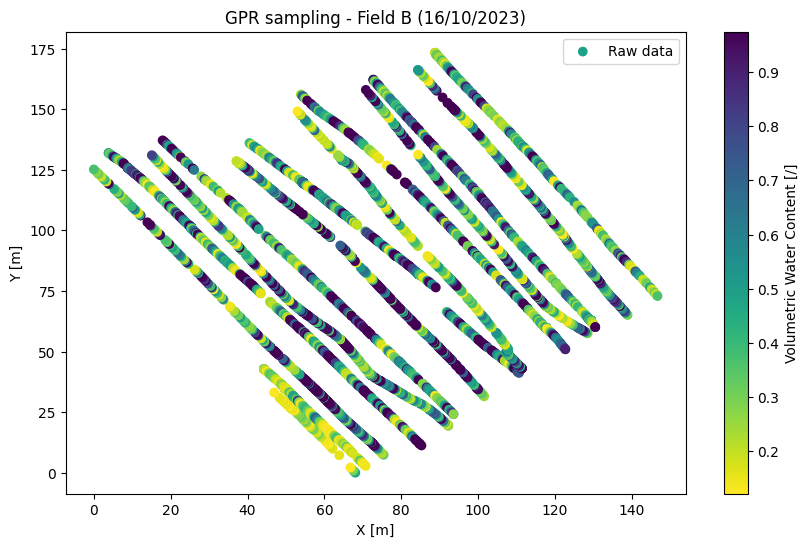

In [4]:
# Instance creation
gpr_b = GprAnalysis(field_letter="B", sample_number=6)  # Sample number [0-11] # FIELD_A/B_PATHS
# Raw Sample
gpr_b.plot_raw_data()

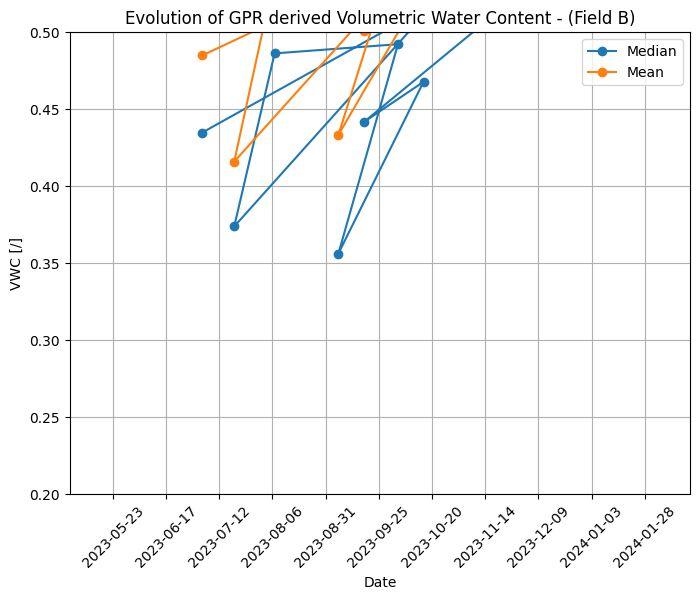

In [5]:
# Median evolution (raw data)
gpr_b.plot_mean_median(plot=True)

### Choosing the variogram model

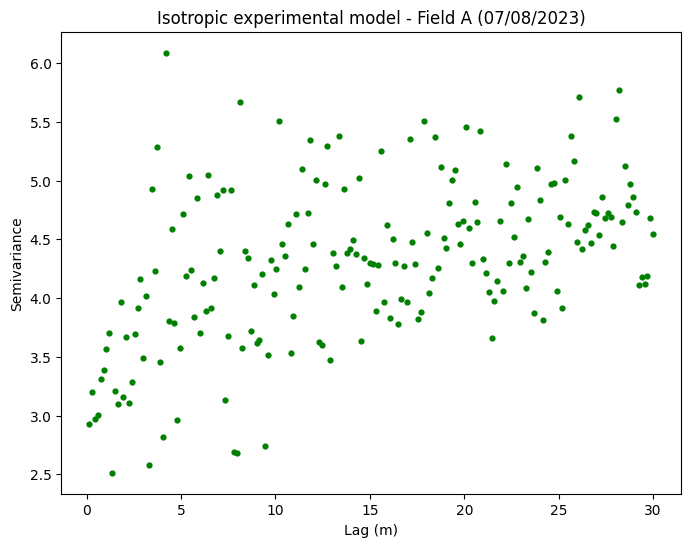

In [6]:
experimental_vario_a = Variogram(resolution=0.00002, field_letter="A", sample_number=0)

experimental_vario_a.determ_experimental_vario();
# ; hide output of the cell

In [7]:
experimental_vario_a.fit_models()

KeyboardInterrupt: 

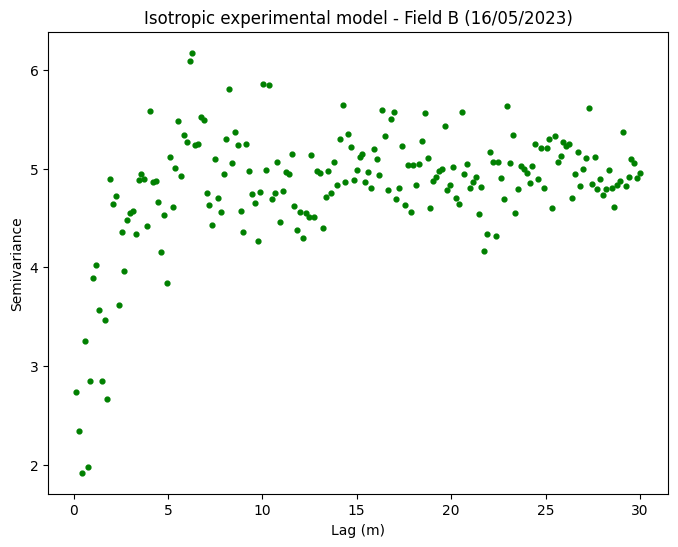

In [ ]:
experimental_vario_b = Variogram(resolution=0.00002, field_letter="B", sample_number=0)

experimental_vario_b.determ_experimental_vario()
# ; hide output of the cell

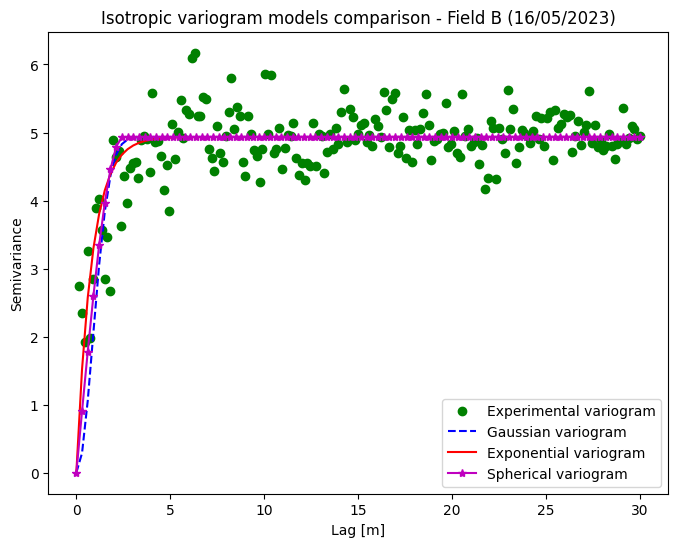

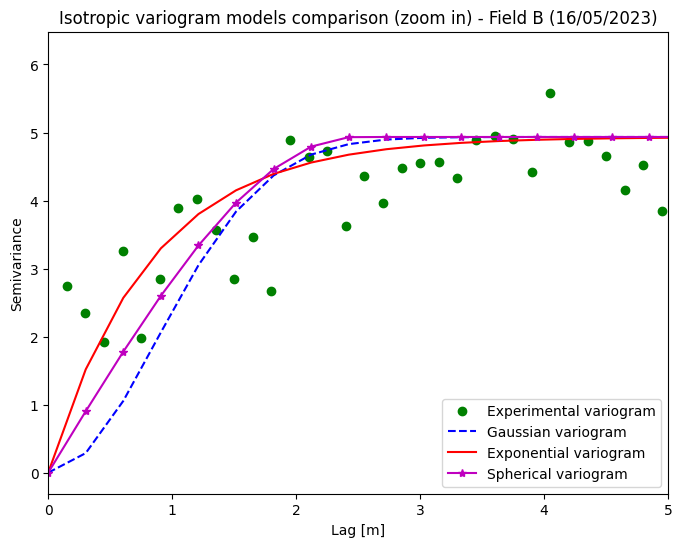

In [ ]:
experimental_vario_b.fit_models()

### Kriged data

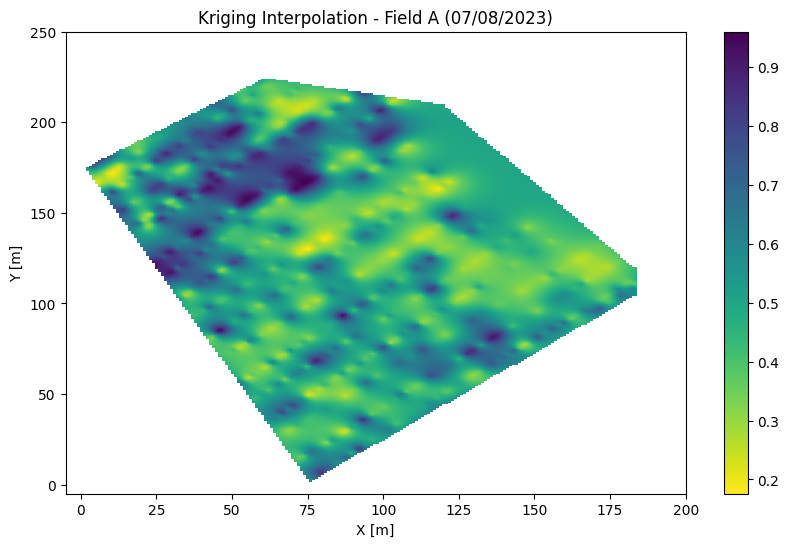

In [ ]:
gpr_a.kriging(plot=True)

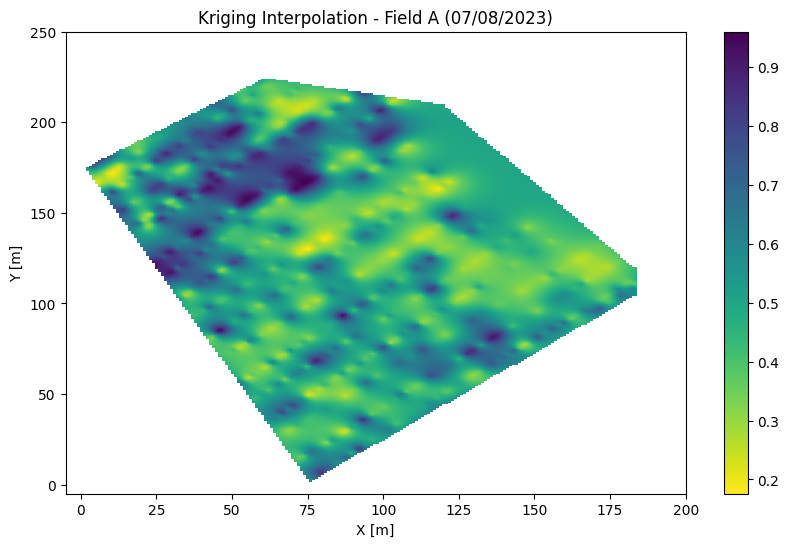

KeyboardInterrupt: 

In [ ]:
GprAnalysis(field_letter="A", sample_number=0).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=1).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=2).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=3).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=4).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=5).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=6).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=7).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=8).kriging(plot=True) # A/B # Sample number [0-9]
GprAnalysis(field_letter="A", sample_number=9).kriging(plot=True) # A/B # Sample number [0-9]

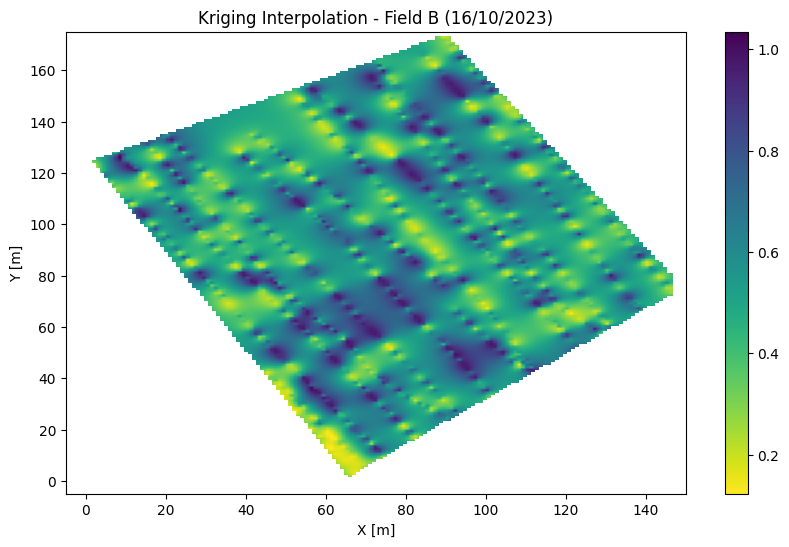

In [ ]:
gpr_b.kriging(plot=True)

## TDR Verification

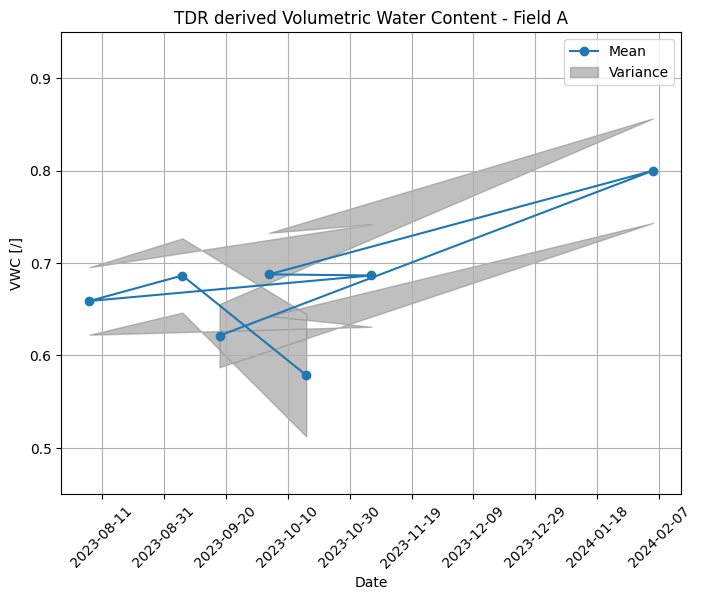

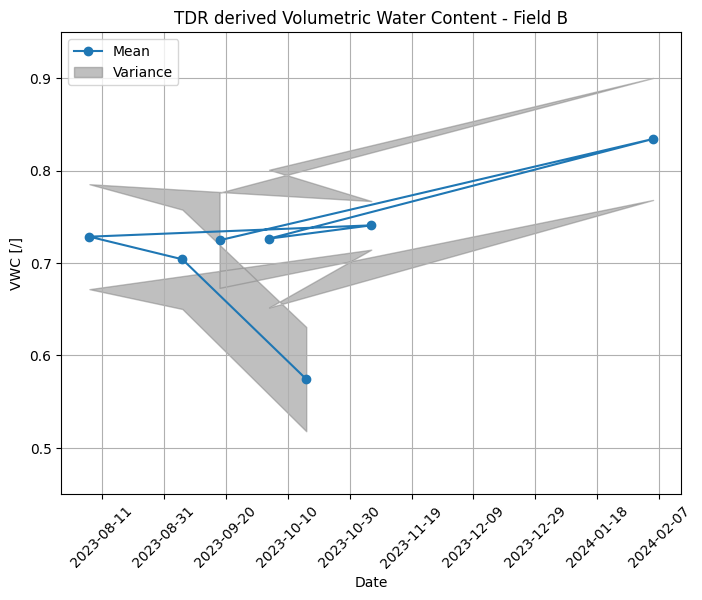

In [3]:
tdr_verif = TdrAnalysis()
tdr_verif.plot_tdr_evolution()

## Rainfall Analysis

/Users/jverbois/python_gab/Master-Thesis/classes.py:605: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


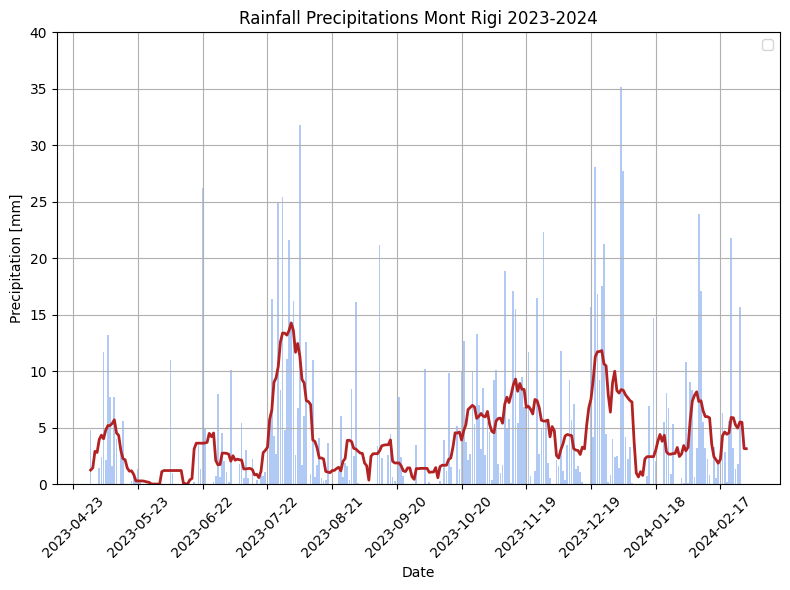

In [2]:
rf_mr = Rainfall()
rf_mr.plot_data()

## Multispectral analysis

### TVDI

The formula used for the Temperature Vegetation Dryness Index (TVDI) calculation is:

$$ \text{TVDI} = \frac{\text{LST} - T_{\text{min}}(\text{NDVI})}{T_{\text{max}}(\text{NDVI}) - T_{\text{min}}(\text{NDVI})} $$

Where:
- LST is the Land Surface Temperature for a given pixel.
- T max NDVI is the maximum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{max}}(\text{NDVI}) = a \cdot \text{NDVI} + b $$
- T min NDVI is the minimum temperature for a given NDVI value, typically represented as a linear function:
  $$ T_{\text{min}}(\text{NDVI}) = c \cdot \text{NDVI} + d $$

Here the specific linear functions used were:

$$ T_{\text{max}}(\text{NDVI}) = 40 \cdot \text{NDVI} + 300 $$

$$ T_{\text{min}}(\text{NDVI}) = 20 \cdot \text{NDVI} + 250 $$


In [ ]:
multi_a = MultispecAnalysis(
    temperature_raster=MultispecAnalysis.TEMPERATURE_RASTER, ndvi_raster=MultispecAnalysis.NDVI_RASTER
)

multi_a.calculate_tvdi()

RasterioIOError: D:/Cours bioingé/BIR M2/Mémoire/Data/thermal/MR20240205_georeferenced_thermal_cali.tif: No such file or directory